In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
np.random.seed(99)

In [3]:
%run ./Autocorrelation_data.ipynb
%run ./ESN.ipynb
%run ./Reconstruct.ipynb
%run ./Plot_TDI.ipynb

In [4]:
# Training data setup
N_washout = 50
N_train   = 5000
N_tstart  = N_washout
N_test    = N_train

strength_list = [1,0]
sigma_dyn, sigma_obs = 5e-1, 0

In [5]:
dots_colors = ['midnightblue', 'tab:brown']

A1 = np.array([[0,1,0],[0,0,1],[0,0,0]], dtype='float')
A2 = np.array([[0,1,0],[0,0,0],[0,1,0]], dtype='float')

A_S = [A1, A2]


alpha_list = [0.8]
f_list = [f1, f1, f1]

N_data = 100
Time_Series_Data = []
All_TDI_categorized = []
for A in A_S:
    
    N_x = len(A)
    N_dim   = N_x # dimension of inputs (and outputs)
    N_units = 100 * N_dim #units in the reservoir
        
    for alpha in alpha_list:
        print(f'A=\n{A}')
        print(f'alpha={alpha}')
        
        Time_Series_Data.append([])

        TDI_categorized = []
        edge_counts = []
        for s in strength_list:
            edge_count = np.sum(np.array(A == np.ones((N_x, N_x)) * s, dtype=int))
            if s == 0:
                edge_count -= N_x
            edge_counts.append(edge_count)
            TDI_categorized.append(np.zeros((N_data, edge_count)))

        for n_data in range(N_data):
            X = gen_data(N_x, A, N_tstart+N_test, np.ones(N_x)*alpha, f_list, c = 0.3, sigma_dyn = sigma_dyn, sigma_obs = sigma_obs)

            Time_Series_Data[-1].append(X)

            # washout
            X_washout = X[:N_washout]
            # training
            X_t = X[N_washout:N_washout+N_train-1]
            Y_t = X[N_washout+1:N_washout+N_train]

            X_test = X[N_tstart:]

            esn = ESN(N_units, N_dim, N_dim, sigma_in=1)
            esn.train(X_washout, X_t, Y_t)

            N_net, N_rep, N_evo = 15, 50, 1
            TDI_net = np.zeros((N_net, N_x, N_x))
            for net in range(N_net):
                TDI_net[net,:,:] = cal_TDI(esn, X_test, N_x, 1, 0, 0, N_rep, N_washout, N_evo)
            TDI = np.mean(TDI_net, axis=0)

            for strength_index in range(len(strength_list)):
                tdi_tmp = []
                xi,xj=np.where(A==strength_list[strength_index])
                for item in zip(xi,xj):
                    if item[0] == item[1]:
                        continue
                    tdi_tmp.append(TDI[item[0], item[1]])
                TDI_categorized[strength_index][n_data] = np.array(tdi_tmp)
                
        t_stat, p_value = stats.ttest_ind(TDI_categorized[0].flatten(), TDI_categorized[1].flatten())
        print(p_value)
                
        All_TDI_categorized.append(TDI_categorized)
        
        result = [np.array(TDI_categorized[0]), np.array(TDI_categorized[1])]
        correct = np.min(result[0],axis=1) > np.max(result[1],axis=1) if strength_list[0] > strength_list[1] else np.max(result[0],axis=1) < np.min(result[1],axis=1)
        print(f'correct: {np.sum(np.array(correct, dtype=int))} / {N_data}')

A=
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
alpha=0.8
1.8496624278393146e-125
correct: 100 / 100
A=
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]
alpha=0.8
5.480052558489146e-164
correct: 97 / 100


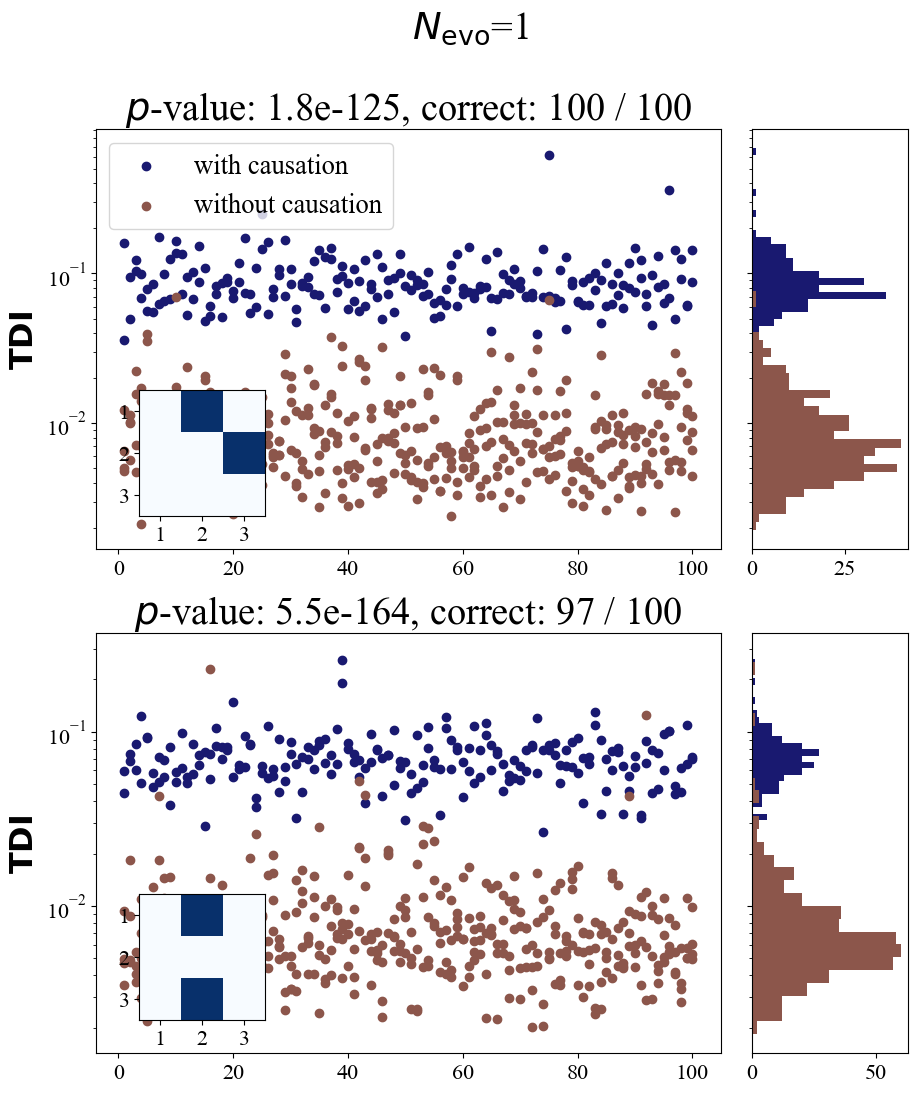

In [9]:
%run ./Plot_TDI.ipynb

plot_dot(A_S, All_TDI_categorized, N_data, strength_list, filename='AC_repeat', suptitle=f'$N_\mathrm{{evo}}$={N_evo}')

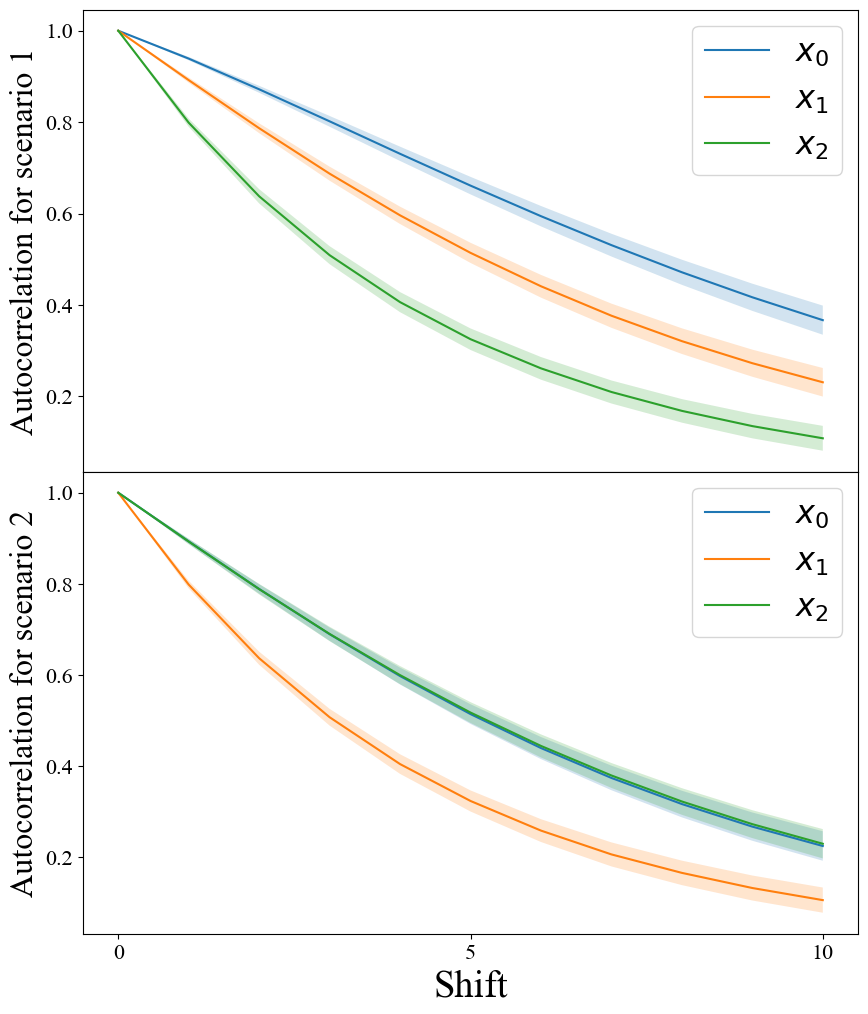

In [7]:
max_shift = 11
autocorrelation_x = []
autocorrelation_y = []
for A in A_S:
    N_x = A.shape[0]
    autocorrelation_x.append(np.zeros((N_x, N_data, max_shift)))
    
for s in range(len(A_S)):
    for data in range(N_data):
        X = Time_Series_Data[s][data]
        N_x = A_S[s].shape[0]
        for node in range(N_x):
            autocorrelation_x[s][node, data, 0]=np.corrcoef(X[:, node], X[:, node])[0,1]
        for shift in np.arange(1,max_shift, 1):
            for node in range(N_x):
                autocorrelation_x[s][node, data, shift]=np.corrcoef(X[:-shift, node], X[shift:, node])[0,1]

fig = plt.figure(figsize=(10, 6*len(A_S)))
axs = fig.subplots(len(A_S), 1, sharex=True)
fig.subplots_adjust(hspace=0)

for s in range(len(A_S)):
    N_x = A_S[s].shape[0]
    
    mean_x = np.mean(autocorrelation_x[s], axis=1)
    std_x = np.std(autocorrelation_x[s], axis=1)
    
    ax = axs[s]
    for node in range(N_x):
        ax.plot(np.arange(max_shift), mean_x[node,:], label=f'$x_{node}$')
        ax.fill_between(np.arange(max_shift), mean_x[node,:]-std_x[node,:], mean_x[node,:]+std_x[node,:], alpha=0.2)

for ax in axs:
    ax.legend(loc='upper right', fontsize='x-large')
    
axs[1].set_xlabel('Shift', fontsize='xx-large')
for s in range(len(A_S)):
    axs[s].set_ylabel(f'Autocorrelation for scenario {s+1}', fontsize='x-large')
    axs[s].set_xticks(np.arange(0,max_shift, 5))
    
plt.show()